In [1]:
# imports
import torch
import InferPSF
import numpy as np
from astropy.io import fits
import os
import sys
from scipy.signal import convolve2d as conv
from scipy.special import i1 # modified bessel function of order 1
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

PyTorch version: 1.6.0


In [2]:
## Specify a few useful functions ##
def convert_to_tensor(data):
    # converts np array to F32 tensor
    data = data.astype(np.float32)
    data = np.array([[data]])
    tensor = torch.from_numpy(data)
    return tensor

def crop(image, crop_size):
    # symmetric crop around image border
    return image[crop_size:image.shape[0]-crop_size, crop_size:image.shape[1]-crop_size]

## save results
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

##################################################################################################
## as implemented in Salahat et al. 2013 for approximating the modified Bessel function of the first kind

coeffs = torch.Tensor([[0.1682, 0.7536, 0.2667, 0.4710, 0.1121, 0.9807, 2.41e-9, 1.144],
                   [0.1472, 0.9739, 0.4916, -163.40, 0.1055, 0.8672, 0.06745, 0.995],
                   [0.4450, -0.715, 0.1110, 0.9852, -0.00018, 1.0795, 0.05471, 0.5686],
                   [0.2382, 0.2343, 0.1304, 0.8554, 0.00326, 1.0385, 0.07869, 0.946]])

#coeffs = coeffs.to(device)

def I1_vectorised(argument, coeffs):

        z0 = argument[argument >= 0]
        z0 = z0[z0 <= 11.5]
        z0 = z0.reshape(len(z0), 1)

        z1 = argument[argument > 11.5]
        z1 = z1[z1 <= 20]
        z1 = z1.reshape(len(z1), 1)

        z2 = argument[argument > 20]
        z2 = z2[z2 <= 37.25]
        z2 = z2.reshape(len(z2), 1)

        z3 = argument[argument > 37.25]
        z3 = z3.reshape(len(z3), 1)

        a0, a1, a2, a3 = coeffs[:,0], coeffs[:,2], coeffs[:, 4], coeffs[:,6]
        b0, b1, b2, b3 = coeffs[:,1], coeffs[:,3], coeffs[:, 5], coeffs[:,7]

        def linalg(z, a, b):
            expz = torch.exp(z @ b.reshape(1, len(b)))
            ab = a*b
            out = expz @ ab
            return out

        out0, out1, out2, out3 = linalg(z0, a0, b0), linalg(z1, a1, b1), linalg(z2, a2, b2), linalg(z3, a3, b3)

        out = torch.cat((out0, out1, out2, out3))

        return out
    

## negative log-likelihood
# EMCCD detector parameters
sigma, f, gain = 60., 25.8, 300. # readnoise, ADU conversion factor, EM gain

def nll(prediction, data, sigma, f, gain, offset, param_vector, lam):
    
    # collapse everything to 1D
    prediction, data = prediction.flatten(), data.flatten()
    
    # for convenience, sort data, and realign prediciton for the data so that pixel pairs correspond
    data, indices = data.sort()
    prediction = prediction[indices]

    # define 'pi' as a tensor
    pi = torch.from_numpy(np.array(np.pi))
    
    # define offset as tensor
    offset = torch.from_numpy(np.array(offset))
    
    # convert ADU counts to appropriate dimensions
    g = f*(data - offset) # (e-_EM / ADU) * ADU = e-_EM
    n = (f/gain)*prediction # (e-_EM / ADU) * (e-_phot / e_EM) * ADU = e-_phot

    ##### gaussian read noise #####
    pdf_readout = torch.exp(-n) * (1./torch.sqrt(2*pi*sigma**2)) * torch.exp(-0.5*(g/sigma)**2)

    ##### EM gain noise #####
    # only defined for g>0
    g_pos = g[g>0]
    n_pos = n[g>0]

    # require n_pos > 0
    n_pos = torch.clamp(n_pos, min=1e-30)

    # evaluate modified bessel function of first order
    x = 2*torch.sqrt((n_pos*g_pos)/gain)
    bessel = I1_vectorised(x, coeffs)
    
    # EM pdf
    pdf_EM = torch.exp(-n_pos - (g_pos/gain)) * torch.sqrt(n_pos/(g_pos*gain)) * bessel

    # add EM pdf to readout pdf for g>0 pixels
    pdf_pos = pdf_readout[g > 0] + pdf_EM
    pdf_neg = pdf_readout[g <= 0]

    # plug everything back together and compute the log-likelihood
    pdf = f*torch.cat((pdf_neg, pdf_pos)) # convert to 1/ADU = (e-_EM/ADU) * (1/e-_EM)
    
    ll = torch.sum(torch.log(pdf))
    
    # L1/L2-regularisation
    #prior = - lam * (param_vector)**2
    #prior = - lam * torch.abs(param_vector)
    
    ### create high frequency version of image by applying derivative filters ###
    
    ## create derivative filters and cast as tensors
    sy = np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])

    sx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])
    
    # weights need to be [1, 1, xd, yd]
    syt = torch.Tensor(sy)[None, None, : ,:]
    sxt = torch.Tensor(sx)[None, None, : ,:]
    
    # gradient images
    xgrad = torch.nn.functional.conv2d(param_vector, sxt, padding=1)
    ygrad = torch.nn.functional.conv2d(param_vector, syt, padding=1)
    
    '''
    plt.imshow(xgrad[0][0].detach(), origin='lower')
    plt.colorbar()
    plt.show();
    
    plt.imshow(ygrad[0][0].detach(), origin='lower')
    plt.colorbar()
    plt.show();
    '''
    
    ## l1 / l2 norm of high frequencies 
    #prior = - lam * (torch.abs(xgrad + ygrad) / (xgrad + ygrad)**2)
    #prior = - lam * ((torch.abs(xgrad)/(xgrad)**2) + (torch.abs(ygrad)/(ygrad)**2))
    '''
    x1_x2 = torch.abs(xgrad)/(xgrad)**2
    y1_y2 = torch.abs(ygrad)/(ygrad)**2
    
    with torch.no_grad():
        if torch.isnan(y1_y2).any() == True:
            print('NaNs in ygrads... replacing')
            #y1_y2[torch.isnan(y1_y2) == True] = torch.nanmedian(y1_y2)
            y1_y2[torch.isnan(y1_y2) == True] = torch.from_numpy(np.nanmedian(y1_y2.detach())).astype(float)

        if torch.isnan(x1_x2).any() == True:
            print('NaNs in xgrads... replacing')
            #x1_x2[torch.isnan(x1_x2) == True] = torch.nanmedian(x1_x2)
            x1_x2[torch.isnan(x1_x2) == True] = torch.from_numpy(np.nanmedian(x1_x2.detach())).astype(float)

    
        ## implement some sort of clip against bad grad values
        clip_x1_x2 = np.percentile(x1_x2.detach(), 99)
        clip_y1_y2 = np.percentile(y1_y2.detach(), 99)

        print(clip_x1_x2, clip_y1_y2)
        
    x1_x2[x1_x2 > clip_x1_x2] = clip_x1_x2
    y1_y2[y1_y2 > clip_y1_y2] = clip_y1_y2
    
    prior = - lam * (x1_x2 + y1_y2)
    '''
    
    '''
    x1, y1 = torch.abs(xgrad), torch.abs(ygrad)
    
    with torch.no_grad():
        ## implement some sort of clip against bad grad values
        clip_x1 = np.percentile(x1.detach(), 95)
        clip_y1 = np.percentile(y1.detach(), 95)
        
    x1[x1 > clip_x1] = clip_x1
    y1[y1 > clip_y1] = clip_y1

    prior = - lam * (x1 + y1)
    '''
    
    try:
        x2, y2 = xgrad ** 2, ygrad ** 2

        with torch.no_grad():
            ## implement some sort of clip against bad grad values
            clip_x2 = np.percentile(x2.detach(), 99)
            clip_y2 = np.percentile(y2.detach(), 99)

        x2[x2 > clip_x2] = clip_x2
        y2[y2 > clip_y2] = clip_y2

        prior = - lam * (x2 + y2)

        print('ll:', ll)
        print('prior:', torch.sum(prior))
        
        ll += torch.sum(prior)
    
    except TypeError:
        print('TypeError...')
    
    return -ll

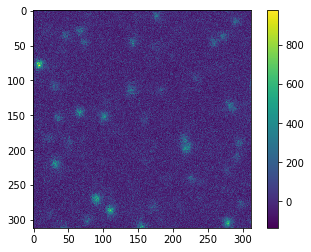

In [3]:
## load LI spool and initial estimate of the scene

# crop images by this much...
crop_size = 100

# cycle through reduction directory
path = '/media/jah94/Seagate_Expansion_Drive#2/Reduction/OGLE_spools_test_2mins'
LI_spool = []
for d, s, files in os.walk(path):
    for file in files:
        #if 'OGLE_000100' in file:
        if 'OGLE_' in file:
            LI_spool.append(file)

#import random
#random.shuffle(LI_spool)
            
#print(LI_spool)
         
# initialise scene with TLI run
tli_scene = fits.getdata(os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.fits'))
scene = crop(tli_scene[0], crop_size) # top 1%, cropped
#scene += crop(tli_scene[1], crop_size)
#scene += crop(tli_scene[2], crop_size)

#for i in range(1, 4):
#    scene += crop(tli_scene[i], crop_size)
#stacked_scene = fits.getdata("Downloads/OGLE-III-BLG101_Llr_2019-07-18_00008.stack.fits")
#scene = crop(stacked_scene, crop_size) # top 1%, cropped


#frame = fits.getdata(os.path.join(path, 'OGLE_000010.fits'))
#scene = crop(frame, crop_size) # top 1%, cropped

# sky subtract
scene -= np.median(scene)

# positivity
#epsilon = 1e-10
#scene[scene < epsilon] = epsilon

## plot initial estimate of scene
s0 = np.copy(scene)
plt.imshow(s0)
plt.colorbar();

In [4]:
## or maybe we want to load a saved estimate of the scene?
#scene_file = 'SceneEstimates/1131_phik2_L2grad_1e-8_L11e4_pass1.fits'
#scene = fits.getdata(scene_file)
#plt.imshow(scene, origin='lower')
#plt.colorbar();

In [5]:
# convert scene to tensor
scene = convert_to_tensor(scene)
#s0 = np.copy(scene[0][0].numpy())
scene.requires_grad = True # the scene is a parameter

In [7]:
## Tresh!!

list_of_scenes = []
list_of_kernels = []
global_losses = []

for p in range(0, 6):
    #for p in range(3, 6):

    for n, image in enumerate(LI_spool):

        # option to limit updates
        if n < 1e5:

            print('Image:', n)

            # load image and apply crop
            y = crop(fits.getdata(os.path.join(path, image)), crop_size)

            # sky subtract
            #y -= np.median(y)

            ## convolve scene with near diffraction limited kernel
            ## we'll go for a symmetrical gaussian
            ks = 19
            phi_k = 2
            nx, ny = (ks, ks) # kernel object shape
            xg, yg = np.meshgrid(range(nx), range(ny))
            xc, yc = (np.int(nx/2), np.int(ny/2))
            kernel = np.exp(-0.5 * ((xg - xc) ** 2 + (yg - yc) ** 2) / phi_k ** 2)
            kernel /= np.sum(kernel) # normalise to 1
            kernel = convert_to_tensor(kernel)

            # kernel convolved scene
            # we do not want to start adding operations to the computational graph here, as this will screw
            # with the 'PSF' inference. This is fine, as the PSF inference and scene update can be split
            # into two independent stages.
            with torch.no_grad():
                kc_scene = torch.nn.functional.conv2d(scene, kernel, bias=None, padding=np.int(((ks - 1)/2))) 

            # infer 'dPSF', differential background and bias offset
            kernel_size = 25

            psf, sky, offset, placeholder = InferPSF.DIA(kc_scene,
                                                         y,
                                                         np.ones(y.shape),
                                                         read_noise = 0.,
                                                         ks = kernel_size,
                                                         lr_kernel = 1e-4,
                                                         lr_B = 1,
                                                         Newton_tol = 1e-10,
                                                         poly_degree=0,
                                                         fast=True,
                                                         tol = 1e-6,
                                                         max_iterations = 2500,
                                                         positivity = True,
                                                         phi = 3e3,
                                                         show_convergence_plots=False)

            if np.isnan(psf).any() == False:

                # convert y and psf to tensors
                y, psf = convert_to_tensor(y), convert_to_tensor(psf)

                # re-compute the kernel convolved scene
                kc_scene = torch.nn.functional.conv2d(scene, kernel, bias=None, padding=np.int(((ks - 1)/2))) 

                ## convolve the scene to match the sky subtracted image
                # prediction = psf*scene + sky (...the bias drift offset enters later)
                prediction = torch.nn.functional.conv2d(kc_scene, psf, bias=None, padding=np.int(((kernel_size - 1)/2))) 
                prediction += torch.tensor(sky)


                print(kc_scene.size())
                # compute the loss (negative log-likelihood)
                loss = nll(prediction, y, sigma, f, gain, offset, kc_scene, lam=0)

                global_losses.append(loss.item())

                # steepest descent - note we update w.r.t to the scene,
                # we update in our parameters!
                dl_ds = torch.autograd.grad(loss, kc_scene)[0]


                # step size
                alpha_t = 1e3
                #alpha_t = 3e3
                #alpha_t = 1e4

                # take a single gradient step
                scene = scene - alpha_t * dl_ds

                # enforce positivity (+ sky subtract)
                #with torch.no_grad():
                #    scene.clamp_(min=epsilon)

                if n % 10 == 0:

                    plt.figure()
                    plt.title('Inferred PSF')
                    plt.imshow(psf[0][0], origin='lower')
                    plt.colorbar();
                    #plt.savefig('Inferred_PSF_PGN.png')
                    plt.show();


                    #plt.imshow(upper_bound[0][0], origin='lower')
                    #plt.show();
                    #plt.imshow(lower_bound[0][0], origin='lower')
                    #plt.show();

                    plot_scene = scene[0][0].detach().numpy()

                    plt.figure()
                    plt.imshow(plot_scene, origin='lower')
                    plt.colorbar()
                    plt.show();

                    plt.figure()
                    plt.imshow(plot_scene - s0, origin='lower')
                    plt.colorbar()
                    plt.show();

                    list_of_scenes.append(plot_scene)
                    list_of_kernels.append(psf)

                    #save_numpy_as_fits(plot_scene, 'SceneEstimates/%d_phik2_L2grad_0_L1_3e3_pass%d.fits' % ((n+1), p))
                    #                    #'SceneEstimates/s_kc_updatein_kc_scene_%d_phik2.fits' % (n+1))
                    #                
                    #                   'SceneEstimates/%d_Top3cut_phik2_negative_clippedupdate_kernel_pass%d.fits' % ((n+1), p))


Image: 0
--- Time to move data onto GPU: 0.00038933753967285156 ---
True
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 312, 312]) torch.Size([1, 1, 312, 312]) torch.Size([1, 1, 25, 25]) torch.Size([1])
Starting optimisation
Iteration:0, loss=295307.625000, P=0.000625
Parameter containing:
tensor([2.4853341579], device='cuda:0', requires_grad=True) tensor([1.5000000000], device='cuda:0', requires_grad=True)


KeyboardInterrupt: 

At last! I really think I've made a breakthrough with this project. In Magain et al's treatment of the light deconvolution problem, it is pointed out that many classical deconvolution approaches are attempting an impossible task; to recover the "true" image, $s$, as if it were observed with a perfect instrument. This makes no sense; it is impossible to represent the continuous intensity distribution observed by such a device on a sampled pixel grid. Indeed, it is irrelevant to even think about that as the aim of the deconvolution algorithm. Instead, we should attempt to deconvolve to an image that would have been observed by a *better* instrument, with a resolution that does not violate the sampling theorem. In this framework, the task of the inference is to infer $\tilde{s} = k \otimes s$, where $k$ is some user-specified kernel that ensures that $\tilde{s}$ is well sampled (or at least critically sampled?).

This decomposition of the PSF into $\phi = d\phi \otimes k$ requires convolving the current estimate of $s$ with $k$ at each iteration. Consequently, correlated pixel noise is introduced into $\tilde{s}$. It may be useful to introduce a maximum/minimum relative per-pixel update condition, like in the robust stats paper, to mitigate the effect of noise.

**How to take excessively noisy updates *in-between* point sources?**

Some experimenting suggests this only becomes a *big* problem if positivity is enforced on the model image. Just to note, it is reasonable to enforce positivty on the PSF / blur kernel though!

- Reduce and/or anneal the step-size
    - This really is another separate problem I'll need to tackle. What is the argument for reducing the step size? Well, once you get close to the/a minimum of the scalar objective function you're optimising. But how to know we're (approaching) that in an online optimisation scheme?
- Use a stricter clip update
    - How does the positivity constraint (or lack of!) affect how this should be implemented... THINK!!
- Some sort of median filter... probably will badly affect low SNR sources
    - see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html
    - But what about just applying once for the initial guess for k * s?
        - Not satisfying! Median filters blur edges, nor do they effectively remove the noise.
- Set a small 'epsilon' number as noise floor rather than 0
    - Setting this at 0.001 introduces noise... similar to that which you see without using an update clip
    - Setting this at 1e-10
        - This is *only* important if positivity is being enforced.
- Use more images for the initialisation 
    - This guards againts noisy pixels in the intialisation that persist... we want to keep noise fluctuations to an absolute minimum for the initial estimate of the model, since these are very bad initial estimates for the 'best' value of these pixels, and they tend to blow-up
        - Tried initialising with the Top 3 Cuts = 150 frames. This suggested I need to use a larger step size if more images are used to initialise the model. And still struggling to "see" sources not clearly observable in the initialisation for the model
    - Note that the PSF inference starts to become tricky if more than the Top 3 best cuts are used... The photometic scaling will tend to 1e-3 and less (~1300 frame in stack)
- Initialise with  mean/median over all frames
    - Same reason as above
    
     
**Recovering very low SNR sources**

This now seems to be the main problem. One issue with re-writing the inference task as $k * s$ is that we must convolve $s$ with $k$! This introduces correlated pixel noise into the model during the updates. This may be in part responsible for why it's apparently so challenging to recover the very faintest sources in the final scene. In addition to the fact these signals are buried in the noise on any given frame; that we can't recover them may speak to the inadeqeuncy of the statistical model.

See Hogg's post on this from back in the day: https://hoggresearch.blogspot.com/2012/05/imaging-imaging-imaging-atlas.html

How is the performance dependent on the degree of blurring? What about trialling a dataset obtained under very good seeing and another under bad seeing. What about 30 Hz frames too??

It just may not be possible to recover these sources with this algorithm. That's fine; we shouldn't be expected to solve *everything*! Indeed, below a certain SNR similar flavours of the Hirsch MFOBD algorithm will fail http://aspbooks.org/publications/522/413.pdf .


**To me, most if not all the above problems are caused by enforcing positivty on the model image. There's no longer any compelling reason to enforce this condition; it introduces noise, is highly senstive to the initialisation, and badly affects very faint sources!**

## Lessons Learned

- Re-parameterising the problem such that the task for the inference is to infer $k * s$ provides a satisfying solution to the problem of "ringing" around point sources
    - This also appears to do away with the need to enforce *positivity* on the model image. I get "just as good" qualitative results whether I do or do not constrain the model to be positive. There appears then to be no good reason to constrain pixels in this way. For this problem, there will be very many sources below the detection threshold in any given frame; these sources will be badly affected by the positivity constraint
        - Unfortunately, even if I do allow the model to be negative, the algorithm still struggles to recover very low SNR sources, that are undoubtedly well below the detection threshold in any given (data) image. However, it is able to "push" fluxes into sources that are just barely detectable in the initial model. Given this, I will experiment with a "deeper" intialisation for the model, and see how this affects the performance. Note that this requires tuning the learning rate; numerically, greater the difference in net flux / photometric scale between the model and the data, the higher the learning rate should be.
        - Also, as it is currently implemented, the update clipping function only really seems to effect the case when positivity is enforced. It does (usually?) come into play if pixels are allowed to be negative, but only affects a handful of pixels/parameters. Which is probably a good thing!
            - What effect, if any, would *this* clipping have on faint sources?
            - And what effect might the choice of $k$ have? Is there a motivation to keep $k$ as small as possible? And what is this limit? Certainly, it seems you're safe if this k represents a well-sampled function. But what about the critically sampled case? i.e. $\phi_k = 1$.
                - You would think by keeping $\phi_k$ small, you would improve the per-pixel signal-to-noise. In practice, correlated noise from small kernels seems to destroy this... **AM I SURE YOU NEED TO CONVOLVE THE CURRENT ESTIMATE OF THE SCENE WITH THE KERNEL FOR EACH UPDATE**
            - Results with $\phi_k=1$ aren't any better than with a broader kernel. In fact, the correlated noise structure assocaited with the convolution are worse with a tight kernel, and faint sources are even very hard to distinguish. 
            
**PSF Inference**

- I've been getting good results with setting tol = 1e-5, and requiring that the minimum number of steps taken in 100. I limit the max number of steps to 1000, although I've never seen this reached if tol = 1e-5. But note that you can reach this on occasion of the convergence tolerance is set by the data precision i.e. tol = 1e-6 - 1e-8 regime
- It seems that reuducing the minimum number of steps -- which typically results in inferring a somewhat fatter PSF -- leads to a slight ringing, despite the target of inference being $k * s$. **OR IT COULD BE BECAUSE I SET ALSO CHANGED PHI_K TO 3 - CHECK THIS!!!!**
    - Better results when setting tol < 1e-5, and therefore in effect taking more optimisation steps. But still some hints of the start of ringing around the brighter sources
         - I also turned off the clip updates, so that might also have been acting as a guard. Try running again with $\phi_k = 2$, with the clip updates again turned off, and with tol < 1e-5. This can be directly compared to the previous $\phi_k = 2$ results
             - This doesn't appear to give any better results than when tol = 1e-5. And indeed, the clip updates seem irrelevant in this context.
    - This makes some sense. If the PSF is deconstructed into $\phi = d\phi * k$, then if the inferred $d\phi$ is too wide, then consequently, the $k$ we're aiming to deconvolve too will be too tight, and possibly violate the sampling theorem. We still want the $d\phi$ that we're deconvolving with to capture the "spleckley" pattern of the blur - this really is *the* crucial step in the aglorithm. tol = 1e-6 seems fine, with minimum number of steps > 100 (and max 1000). **This statement appears to be true**

Does the algorithm really struggle to recover faint sources? It may just not have been run for enough iterations. Or the grey-scale stretch is being affected by the brighter sources. We can cut out a region around where faint sources are known to lie to test this.

## (Image) Priors

I had hoped that the quantity of data availabe in a LI spool would be sufficient to constrain the solution. In practice, the MLE for the scene is noisy, and seemingly unable to recover the faintest sources buried in data. Introducing (log) priors could be useful here; we want to guard against excessivley noisy scenes, and, in the best case scenario, be sensitive to very faint fluxes.

The absolute simplest choices that might make sense here are L1 or L2 penalties to our loss function. These disfavour large values in our parameter vector (i.e. $k * s$), pushing the model image to zero unless the data is informative. This should guard against excessively noisy updates, but the effect on point sources is difficult to predict. Indeed, coupled with too large a step-size, this regularisation would push the stellar fluxes towards 0, so some tuning is definitely required.

A key conceptual difference is that L1 regularisation favours both smoothness *and* sparsity. Astronomical image are sparse representations of intensity fields -- in particular, if background subtracted such that the median value of our model is 0 -- so could be interesting to try too.

**L1 / L2 on all frequency bands**: L2 has the effect of suppressing wings of the PSF giving and doesn't do a great job of suppressing noise. L1 on the other hand does a nice job of pushing the noise towards 0, while still allowing flux to be "pushed" into the faintest stars. Unfortunately, this comes at the expense of ring artefacts around the point sources (ah!!). L1 can of course cheat this way - it wants to drive the absolute value of the image model to 0, so if flux associated with stars increases, it can push the wings to be negative to compensate. I guess....?

Fundamentally, while fine for natural images, these sorts of priors might not be great for astronomical scenes...

**L2 on high frequency bands**: Hirsch et al. 2011 penalised their cost function with a L2 norm on the gradients of the model image when data was in low SNR regime. Simplest next thing is to just try that ourselves. $\lambda = 1e-8$ produces bad artefacts, and deconvolves down to a "X" shaped PSF. We really just want to suppress the noise without penalising faint sources... If the data is uniformative, this regularisation should still act to push the noise to 0, but may have more attractive convergence properties than optimising an L1 norm on the gradients.


### Priors on Image Gradients

This is what I should really be looking into applying. It doesn't make a lot of sense to apply regularisation to all frequency bands in the image, but just the highest i.e. those associated with image gradients. We want a sparse background populated with sharp point sources: the ratio of the L1 / L2 norms on the gradients is purported to be able to achieve this, since adding this penalty to our cost function explicity favours sharp spare scenes. Noise lies in these high frequency bands, so if used properly, this prior should de-noise too. So why doesn't it work right here! I must have blundered... it introduces a very correlated background structure to the image.

### Results

**L2**

Tried run with $\lambda = 1e-6$. Effect is to *strongly* deconvolve (i.e. push wings to zero) the bright sources, but doesn't smooth the 'noisy' nature of the inferred scene. Indeed, faint point sources are even harder to pick out from the correlated structure of the noise; maybe trying a broader $k$, although this somewhat defeats the point of deconvolving!

**L1**

Initial run was with $\lambda = 1e-4$, and, quite remarkably, *it works*... mostly! Within the same number of optimsiation steps (with the same learning rate) this does a better job of recovering even the very faintest sources in the scene than the MLE for $k * s$. **It could be that I just need to run the MLE version of several more iterations - so I should definitely try this!** Unfortunately, for this initial run, the regularisation introduced rings around point sources; I'm uncertain as to the cause of this. The best value for the hyperparamter $\lambda$ needs to be tuned empirically, so I'll try out some other values to compare and contrast.

Re the ringing: my suspicion is that this is introduced by inaccuracies in the blur kernel estimation (e.g. see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.362.7737&rep=rep1&type=pdf for (unfreferenced!) note on how this affects Richardson-Lucy updates). Better blur kernel estimation can be most simply achieved by including more data, and in particular, bright sources, into the inference. We can do this by working with a 500x500 pixel image instead, which includes a nice number of bright sources carrying a lot of information on the blurring. **To be robust to bad kernel inference, if loss isnan then exclude update!** Also, in above link: "An important practical point is that after recovering the kernel at the finest level, we threshold small elements of the kernel to zero, thereby increasing robustness to noise. This is similar to other blind deconvolution methods" 

**As of 26/1/21:** See 500x500 image test run. .fits of model were created every 10 updates. A 31x31 blur kernel model was adopted. Ring artefacts still persist, and the deconvolved PSF in the "final" estimate are somewhat broader than when working with the 312x312 image. The inferred blur kernels look correct, and are not badly affected by noise (and indeed, the model image is less noisy), but the kernels are probably dominated by the brightest sources now present in the 500x500 image, hence the difference in results from before. The inferred blur kernel really does matter; the final results are sensitive to this. In this instance, a less noisy model was inferred, but with a broader deconvolved PSF.

In [16]:
x = torch.Tensor([1.]) / torch.Tensor([0.])
torch.isinf(x).item() == True

True